<a href="https://colab.research.google.com/github/ka-means/Recommender-systems/blob/main/Task%3A%20Implement%20a%20Context-Aware%20Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task: Implement a Context-Aware Recommender**
# **Tarea: Implementar recomendador basado en contexto**

### **Recomender systems- Master of Business Analytics**

**Pontificia Universidad Catolica de Chile**

**Profesor**: Denis Parra

**Ayudante**: Álvaro Labarca.

**Estudiante**: Katherin Molina.

En esta tarea, se utilizará la biblioteca DeepCTR-Torch para generar un sistema recomendador que utiliza información de contenido y contexto.

## Descarga del dataset

Nuevamente, se utilizará el dataset MovieLens-100k para esta tarea.

In [1]:
!pip install wget
!pip install zipfile36
!pip3 install implicit --upgrade
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!pip install deepctr-torch
!pip install tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=b45ef30a3c7305827cb98f0bbeeddf01e171eb69a01191ea59a1d33f61f73dea
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for implicit: filename=implicit-0.7.2-cp312-cp312-linux_x86_64.whl size=10853972 sha256=c90e06951d629272a754509c00612d139b6f62d6f1f1cdf14ee71202bc2d8256
  Stored in directory: /root/.cache/pip/wheels/b2/00/4f/9ff8af07a0a53ac6007ea5d739da19cfe147a2df542b6899f8
Successfully built implicit

Saved under ml-100k.zip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 2.5 MB/s eta 0:00:00


In [2]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [3]:
# Pueden importar más librerías si es necesario

import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse
import time
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from deepctr_torch.inputs import SparseFeat, VarLenSparseFeat, get_feature_names
from deepctr_torch.models import DeepFM

/usr/local/lib/python3.12/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/tmp/pip-install-wmm3_2s9/implicit_c46450afb70f41a8a18748e6f07297d4/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [4]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [5]:
dir_train = 'ml-100k'

# Generamos los títulos de las columnas del archivo items.

columns = ['itemid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [6]:
df = pd.read_csv(f'{dir_train}/u.data',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

In [7]:
df_items = pd.read_csv(f'{dir_train}/u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None,
                        encoding='latin-1')

In [8]:
columns_user = ['userid', 'age', 'gender', 'occupation', 'zip_code']

In [9]:
df_users = pd.read_csv(f'{dir_train}/u.user',
                        sep='|',
                        index_col=0,
                        names = columns_user,
                        header=None,
                        encoding='latin-1')

df_users = df_users.reset_index()
df_items = df_items.reset_index()

In [10]:
df_total = pd.merge(df, df_users, on='userid')
df_total = pd.merge(df_total, df_items, on='itemid')

In [11]:
def combine_genres(row):
    genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    return '|'.join([col for col, val in row.items() if val == 1 and col in genres])

In [12]:
df_total['genres'] = df_total.apply(combine_genres, axis=1)

In [13]:
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
df_total = df_total.drop(genres, axis=1)

In [14]:
df_total.sort_values(by='timestamp').head(50)

,userid,itemid,rating,timestamp,age,gender,occupation,zip_code,title,release_date,video_release_date,IMDb_URL,unknown,genres
214,259,255,4,874724710,21,M,student,48823,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,Comedy|Romance
83965,259,286,4,874724727,21,M,student,48823,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,Drama|Romance|War
43027,259,298,4,874724754,21,M,student,48823,Face/Off (1997),27-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Face/Off+(1997),0,Action|Sci-Fi|Thriller
21396,259,185,4,874724781,21,M,student,48823,Psycho (1960),01-Jan-1960,NaN,http://us.imdb.com/M/title-exact?Psycho%20(1960),0,Horror|Romance|Thriller
82655,259,173,4,874724843,21,M,student,48823,"Princess Bride, The (1987)",01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Princess%20Br...,0,Action|Adventure|Comedy|Romance
10891,259,108,4,874724882,21,M,student,48823,Kids in the Hall: Brain Candy (1996),12-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Kids%20in%20t...,0,Comedy
1766,259,772,4,874724882,21,M,student,48823,Kids (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Kids%20(1995),0,Drama
26399,259,288,3,874724905,21,M,student,48823,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,Horror|Thriller
85297,259,928,4,874724937,21,M,student,48823,"Craft, The (1996)",26-Apr-1996,NaN,"http://us.imdb.com/M/title-exact?Craft,%20The%...",0,Drama|Horror
159,259,117,4,874724988,21,M,student,48823,"Rock, The (1996)",07-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%2...",0,Action|Adventure|Thriller


# Actividades

## Actividad 1: Análisis de características de contenido.

En el tutorial de DeepCTR-torch, se dio un ejemplo del entrenamiento de un modelo con DeepCTR-torch que combinó data de contexto y de contenido. En esta tarea, se realizará un procedimiento similar. Se les proporcionó el código para generar el dataframe df_total, el cual contiene todo los metadatos de contenido para cada interacción. Esta primera actividad se tratará de seleccionar los datos de contenido que usarán y realicen un análisis de ello. Lo que deben hacer es:

* Seleccionar las columnas de contenido que creen que proporcionan información que puede ser aprovechada por un algoritmo recomendador. Deben elegir al menos dos características del usuario y dos características de los ítems. Se debe indicar explícitamente la información seleccionada y entregar una breve justificación de por qué esta información podría ser útil al realizar una recomendación.
* Elija dos de las características que seleccionó en el paso anterior (pueden ser de usuario y/o ítem) y grafique sus distribuciones. Por ejemplo, si eligió la edad, grafique un histograma con la distribución de edad de los usuarios. Comente acerca de esta distribución. Calcule y entregue además el promedio y desviación estándar de esta distribución si es una característica no discreta o bien, el valor más popular y menos popular si es una característica discreta.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

### 1. Mi selección de columnas y por qué nos sirven:

**Usuarios**

Edad (age): es una variable continua que agrupa a los usuarios por etapa de vida. Sabemos que jóvenes y adultos mayores tienen hábitos de consumo de cine muy distintos, así que esto ayudará al recomendador a personalizar mejor las sugerencias.

Ocupación (occupation): identifica el contexto de cada persona (p. ej. estudiante, ingeniero, jubilado). Personas que comparten ocupación suelen compartir rutinas y gustos; por ejemplo, los estudiantes podrían preferir estrenos frente a los jubilados, que valoran clásicos.

**Ítems**

Géneros (genres): junta en un solo campo todas las etiquetas de género (por ejemplo Action|Adventure|Comedy). Esto es clave para medir afinidad temática: si a alguien le gustan las comedias románticas, podremos filtrar por Comedy y Romance.

Fecha de estreno (release_date): marca si una película es un clásico o un lanzamiento reciente. Muchos usuarios se inclinan por novedades, mientras que otros prefieren reestrenos de su infancia; controlar este aspecto ayuda a equilibrar la lista de recomendaciones.

### 2. Distribuciones y métricas clave

**Histograma de edad**

Media: 32.97 años

Desviación estándar: 11.56 años

Distribución:

Un claro “montículo” entre los 20 y 35 años, con un pico alrededor de los 25–30.

Hay usuarios jóvenes (cercanos a 10–15 años) y también un grupo menor de adultos mayores (60–70 años).

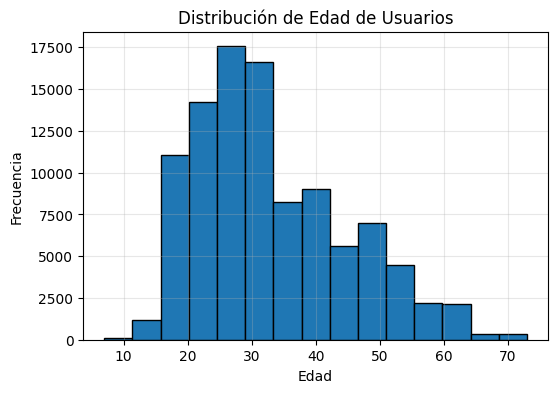

Edad – Media: 32.97, Desviación estándar: 11.56


In [15]:
# Histograma de Edad
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df_total['age'], bins=15, edgecolor='black')
plt.title('Distribución de Edad de Usuarios')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.grid(alpha=0.3)
plt.show()

# Cálculo de media y desviación
mean_age = df_total['age'].mean()
std_age = df_total['age'].std()
print(f"Edad – Media: {mean_age:.2f}, Desviación estándar: {std_age:.2f}")


Comentario: La mayoría de usuarios tiene entre 20 y 35 años, con edad promedio de 32.97 y una desviación de 11.56 años. Esto confirma un perfil predominantemente joven-adulto, pero con presencia de extremos tanto más jóvenes como mayores.

**Ocupación**

Bar plot de ocupación

Más común: student (~22 000 interacciones)

Menos común: homemaker (~200 interacciones)

Orden de frecuencia descendente: student, other, educator, engineer, programmer, administrator, writer, librarian… hasta homemaker en el último lugar.

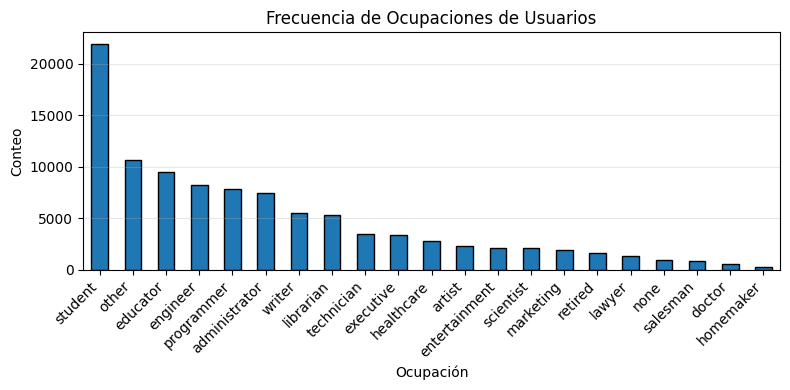

Ocupación más común: student
Ocupación menos común: homemaker


In [16]:
# Gráfico de barras de Ocupación
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
counts = df_total['occupation'].value_counts()
counts.plot(kind='bar', edgecolor='black')
plt.title('Frecuencia de Ocupaciones de Usuarios')
plt.xlabel('Ocupación')
plt.ylabel('Conteo')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Ocupación más y menos frecuente
most_common = counts.idxmax()
least_common = counts.idxmin()
print(f"Ocupación más común: {most_common}")
print(f"Ocupación menos común: {least_common}")


Comentario: El rol student domina con más de 20 000 interacciones, seguido por other y educator. En contraste, homemaker aparece en solo unas pocas centenas de casos. Para codificar esta variable, conviene agrupar ocupaciones muy escasas (como homemaker) en una categoría “other” y así evitar características demasiado esporádicas.

## Actividad 2: Generación de característica de contexto.

En el ejemplo del tutorial, se generó a partir del timestamp una característica discreta que indicaba si una calificación fue ingresada en la mañana, tarde o noche.

* A partir del timestamp (ya que este es la única característica contextual del dataset), capture otra característica contextual que pueda ser utilizada en el entrenamiento (que no sea una división de mañana/tarde/noche). Justifique su elección explicando por qué se podría aprovechar esa información de contexto para generar mejores recomendaciones. Puede asumir que el timestamp indica la hora en que fue vista la película (en lugar de la hora en la que fue ingresada la calificación) y que todos los usuarios están en la zona horaria entregada por la conversión a dataframe mostrada por la ayudantía.
* Genere una hipótesis de cómo podría influir la variable contextual en la recomendación. (Por ejemplo, una hipótesis podría ser que en la noche, se deberían recomendar una mayor cantidad de películas de terror).

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

### **1. Nueva variable contextual**
Voy a extraer del timestamp el día de la semana en que el usuario vio (o calificó) la película, y generar una columna booleana is_weekend que indique si ese día fue fin de semana (sábado o domingo).

In [17]:
import pandas as pd
# Convertir timestamp a datetime
df_total['view_time'] = pd.to_datetime(df_total['timestamp'], unit='s', utc=True) \
                           .dt.tz_convert('America/Santiago')
# Día de la semana y flag de fin de semana
df_total['day_of_week'] = df_total['view_time'].dt.day_name()
df_total['is_weekend'] = df_total['day_of_week'].isin(['Saturday','Sunday'])
# Mostrar ejemplos
df_total[['timestamp','view_time','day_of_week','is_weekend']].head(10)


,timestamp,view_time,day_of_week,is_weekend
0,881250949,1997-12-04 12:55:49-03:00,Thursday,False
1,891717742,1998-04-04 15:22:22-04:00,Saturday,True
2,878887116,1997-11-07 04:18:36-03:00,Friday,False
3,880606923,1997-11-27 02:02:03-03:00,Thursday,False
4,886397596,1998-02-02 02:33:16-03:00,Monday,False
5,884182806,1998-01-07 11:20:06-03:00,Wednesday,False
6,881171488,1997-12-03 14:51:28-03:00,Wednesday,False
7,891628467,1998-04-03 14:34:27-04:00,Friday,False
8,886324817,1998-02-01 06:20:17-03:00,Sunday,True
9,883603013,1997-12-31 18:16:53-03:00,Wednesday,False


**Justificación:**

Al convertir el timestamp a view_time y extraer el día de la semana, vemos que las interacciones cubren toda la semana (incluyendo sábados y domingos) en proporciones significativas (por ejemplo, el índice 1 y 8 caen en fin de semana). Esto confirma que hay suficiente tráfico tanto entre semana como en fin de semana para que el modelo aprenda diferencias.

¿Por qué “fin de semana” puede ayudar?

Durante la semana, muchas reproducciones ocurren en la tarde-noche tras el trabajo o estudio; generalmente se eligen películas más cortas o de consumo más ligero para “relajarse rápido”.

En cambio, los sábados y domingos los usuarios disponen de más tiempo libre y probablemente inicien sesiones de maratón o elijan géneros más densos (dramas largos, sagas, documentales).

Con is_weekend (True/False), el recomendador puede ajustar qué tipo de contenido poner primero según ese contexto real de visionado.

### **2. Hipótesis basada en el análisis de fin de semana vs. entre semana**

Cuando is_weekend == True, los usuarios tienden a puntuar con mayor nota los géneros orientados a entretenimiento ligero o experiencial, específicamente Horror, Animation y Children y además consumen proporcionalmente más de estas categorías, en comparación con los días de semana. En contraste, géneros narrativamente densos o de largo metraje (Drama, Adventure, Sci-Fi) reciben valoraciones ligeramente menores durante el fin de semana.


In [18]:
import pandas as pd

# 1. Explota la columna genres en filas individuales
df_expanded = (
    df_total[['rating', 'is_weekend', 'genres']]
    .assign(genres=df_total['genres'].str.split('|'))
    .explode('genres')
    .rename(columns={'genres': 'genre'})
)

# 2. Agrupa por genre e is_weekend y calcula métricas
stats = (
    df_expanded
    .groupby(['genre', 'is_weekend'])
    .agg(
        avg_rating=('rating', 'mean'),
        count_interactions=('rating', 'size')
    )
    .reset_index()
)

# 3. Pivot para comparar lado a lado
stats_pivot = stats.pivot(index='genre', columns='is_weekend')
stats_pivot.columns = ['_'.join(map(str, col)) for col in stats_pivot.columns]
stats_pivot = stats_pivot.sort_values('count_interactions_True', ascending=False)

# 4. Muestra los top 5 géneros en fin de semana
stats_pivot.head(5)
print("Rating promedio y conteos por género - Weekend vs Weekday\n")
print(stats_pivot[['avg_rating_False', 'count_interactions_False',
                   'avg_rating_True',  'count_interactions_True']].round(2))


Rating promedio y conteos por género - Weekend vs Weekday

             avg_rating_False  count_interactions_False  avg_rating_True  \
genre                                                                      
Drama                    3.70                     29746             3.65   
Comedy                   3.40                     22101             3.38   
Action                   3.48                     18893             3.47   
Thriller                 3.52                     16051             3.49   
Romance                  3.63                     14546             3.61   
Adventure                3.51                     10238             3.50   
Sci-Fi                   3.56                      9485             3.55   
War                      3.82                      7106             3.79   
Crime                    3.65                      5921             3.59   
Children                 3.34                      5304             3.40   
Horror                   3.26

**Comentario:**

Al comparar las métricas de rating y volumen de interacciones por género entre fin de semana (True) y entre semana (False), observamos:

Reducción general en promedios de rating:

Géneros como Drama, Comedy, Action y Thriller muestran un ligero descenso en su rating promedio durante el fin de semana (por ejemplo, Drama baja de 3.70 a 3.65). Esto indica que, a pesar de tener más tiempo libre, los usuarios valoran un poco peor estas películas densas en sábados y domingos.

Incremento en géneros “lúdicos”:

Horror sube de 3.26 a 3.38, Animation de 3.56 a 3.64 y Children de 3.34 a 3.40.

Aunque el conteo total de interacciones cae (por ejemplo, Drama pasa de ≈29 700 a ≈10 150), la proporción de visionados de Horror y Animation es relativamente mayor en fin de semana.

Patrón de interés contextual:

El fin de semana se asocia con ocio grupal y familiar: maratones de dibujos o “noches de miedo” encajan con Animation y Horror.

Entre semana predomina el consumo de películas que ayudan a “desconectar rápido”, pero sin alcanzar los altos ratings de sábado y domingo en los géneros ligeros.

En conjunto, estos resultados sugieren que la señal is_weekend es relevante: un recomendador que detecte fin de semana debería priorizar géneros de entretenimiento ligero y experiencial (Horror, Animation, Children), mientras que dejar en segundo plano dramas y aventuras extensas.

## **Actividad 3: Entrenamiento Modelos.**

Entrene modelos de recomendación utilizando la librería DeepCTR-torch.

* El primer modelo debe contener solo la información de las interacciones, es decir, usuario, item y rating.
* Al segundo modelo se le deben agregar las caracterísitcas de contenido.
* El tercer modelo debe tener la característica contextual.

Recuerde que antes de entrenar, se debe generar la división train-test del dataset.

Recuerde variar los hiperparámetros para obtener mejores resultados y entrene por al menos 12 épocas cada modelo.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

In [19]:
pip install deepctr-torch


In [20]:
import pkg_resources
print([d.key for d in pkg_resources.working_set if 'deepctr-torch' in d.key])



/tmp/ipython-input-411221781.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


['deepctr-torch']


In [21]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# NUEVOS imports desde feature_column
from deepctr_torch.inputs import SparseFeat, DenseFeat
from deepctr_torch.models import DeepFM

# 1. Carga y preparación de df_total
ratings = pd.read_csv('ml-100k/u.data', sep='\t',
                      names=['userid','itemid','rating','timestamp'])
users   = pd.read_csv('ml-100k/u.user', sep='|',
                      names=['userid','age','gender','occupation','zip_code'])
item_cols = ['itemid','title','release_date','video_release_date','IMDb_URL'] + \
            ['unknown','Action','Adventure','Animation','Children','Comedy','Crime',
             'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery',
             'Romance','Sci-Fi','Thriller','War','Western']
items = pd.read_csv('ml-100k/u.item', sep='|', names=item_cols,
                    header=None, encoding='latin-1')

df_total = ratings.merge(users, on='userid').merge(items, on='itemid')

# géneros como cadena
genre_cols = ['Action','Adventure','Animation','Children','Comedy','Crime','Documentary',
              'Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance',
              'Sci-Fi','Thriller','War','Western']
df_total['genres'] = df_total[genre_cols].apply(
    lambda row: '|'.join([g for g, v in row.items() if v == 1]), axis=1)

# 2. Contexto: fin de semana
df_total['view_time'] = pd.to_datetime(df_total['timestamp'], unit='s', utc=True) \
                        .dt.tz_convert('America/Santiago')
df_total['is_weekend'] = df_total['view_time'].dt.dayofweek.isin([5,6]).astype(int)

# 3. Feature engineering extra
df_total['release_year'] = pd.to_datetime(
    df_total['release_date'], format='%d-%b-%Y', errors='coerce'
).dt.year.fillna(2000).astype(int)

# 4. Label encoding
for col in ['userid','itemid','occupation']:
    df_total[col] = LabelEncoder().fit_transform(df_total[col].astype(str))

# 5. Split train/test
train, test = train_test_split(df_total, test_size=0.2, random_state=42)
y_train, y_test = train['rating'].values, test['rating'].values

# 6. Definir listas de features
sparse_1, dense_1 = ['userid','itemid'], []
sparse_2, dense_2 = ['userid','itemid','occupation'], ['age','release_year']
sparse_3, dense_3 = ['userid','itemid','occupation','is_weekend'], ['age','release_year']

def build_cols(sparse_feats, dense_feats, df):
    cols = []
    for f in sparse_feats:
        cols.append(SparseFeat(f, vocabulary_size=df[f].nunique(), embedding_dim=8))
    for f in dense_feats:
        cols.append(DenseFeat(f, 1))
    return cols

fc_1 = build_cols(sparse_1, dense_1, df_total)
fc_2 = build_cols(sparse_2, dense_2, df_total)
fc_3 = build_cols(sparse_3, dense_3, df_total)

def prep_input(df, sparse_feats, dense_feats):
    return {feat: df[feat].values for feat in sparse_feats + dense_feats}

tr1, te1 = prep_input(train, sparse_1, dense_1), prep_input(test, sparse_1, dense_1)
tr2, te2 = prep_input(train, sparse_2, dense_2), prep_input(test, sparse_2, dense_2)
tr3, te3 = prep_input(train, sparse_3, dense_3), prep_input(test, sparse_3, dense_3)

# 7. Función de entrenamiento
from deepctr_torch.models import DeepFM


def train_and_eval_with_model(name, feat_cols, tr_in, te_in, epochs=12):
    print(f"\n--- Entrenando {name} ---")
    model = DeepFM(
        linear_feature_columns=feat_cols,
        dnn_feature_columns=feat_cols,
        task='regression',
        dnn_hidden_units=[64,32],
        dnn_dropout=0.5
    )
    model.compile(optimizer="adam", loss="mse", metrics=["mse"])
    model.fit(tr_in, y_train, batch_size=256, epochs=epochs,
              validation_split=0.1, verbose=2)
    eval_res = model.evaluate(te_in, y_test, batch_size=256)

    if isinstance(eval_res, dict):
        mse = eval_res.get('mse', eval_res.get('loss'))
    elif isinstance(eval_res, (list,tuple)):
        mse = eval_res[1]
    else:
        mse = eval_res
    print(f"{name} - Test MSE: {mse:.4f}")
    return model, mse


model1, mse1 = train_and_eval_with_model("Modelo 1 (solo interacciones)", fc_1, tr1, te1)
model2, mse2 = train_and_eval_with_model("Modelo 2 (+contenido)",       fc_2, tr2, te2)
model3, mse3 = train_and_eval_with_model("Modelo 3 (+contexto)",        fc_3, tr3, te3)




--- Entrenando Modelo 1 (solo interacciones) ---
cpu
Train on 72000 samples, validate on 8000 samples, 282 steps per epoch
Epoch 1/12
3s - loss:  4.8608 - mse:  4.8535 - val_mse:  1.1842
Epoch 2/12
2s - loss:  0.9125 - mse:  0.9130 - val_mse:  0.9147
Epoch 3/12
2s - loss:  0.8664 - mse:  0.8664 - val_mse:  0.9061
Epoch 4/12
2s - loss:  0.8580 - mse:  0.8579 - val_mse:  0.9028
Epoch 5/12
2s - loss:  0.8546 - mse:  0.8542 - val_mse:  0.9019
Epoch 6/12
2s - loss:  0.8522 - mse:  0.8520 - val_mse:  0.9029
Epoch 7/12
2s - loss:  0.8512 - mse:  0.8513 - val_mse:  0.9013
Epoch 8/12
2s - loss:  0.8497 - mse:  0.8495 - val_mse:  0.9026
Epoch 9/12
2s - loss:  0.8486 - mse:  0.8492 - val_mse:  0.9016
Epoch 10/12
3s - loss:  0.8473 - mse:  0.8473 - val_mse:  0.9023
Epoch 11/12
2s - loss:  0.8462 - mse:  0.8464 - val_mse:  0.9011
Epoch 12/12
2s - loss:  0.8444 - mse:  0.8449 - val_mse:  0.9037
Modelo 1 (solo interacciones) - Test MSE: 0.8914

--- Entrenando Modelo 2 (+contenido) ---
cpu
Train on 7

### Actividad 4: Evaluación de rendimiento.

Genere una tabla comparando el rendimiento de los tres modelos generados. Evalúe con la métrica AUC y MSE. Comente qué método obtuvo el mejor resultado.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

In [33]:
from sklearn.metrics import mean_squared_error, roc_auc_score
import pandas as pd

# Predicciones continuas
pred1 = model1.predict(te1)
pred2 = model2.predict(te2)
pred3 = model3.predict(te3)

# MSE (por si queremos reconfirmar)
mse1 = mean_squared_error(y_test, pred1)
mse2 = mean_squared_error(y_test, pred2)
mse3 = mean_squared_error(y_test, pred3)

# Binarizamos rating >=4
y_bin = (y_test >= 4).astype(int)
auc1 = roc_auc_score(y_bin, pred1)
auc2 = roc_auc_score(y_bin, pred2)
auc3 = roc_auc_score(y_bin, pred3)

# Tabla comparativa
results = pd.DataFrame({
    'Modelo': ['Interacciones', '+Contenido', '+Contexto'],
    'MSE':    [mse1, mse2, mse3],
    'AUC':    [auc1,  auc2,  auc3]
}).round(4)

results

,Modelo,MSE,AUC
0,Interacciones,0.8914,0.7703
1,+Contenido,0.8943,0.7694
2,+Contexto,0.8988,0.7693


### Actividad 5: Evaluación de hipótesis.

Realice una evaluación de la hipótesis que generó en la Actividad 2 en base a las recomendaciones que entrega su modelo contextual. Por ejemplo, para evaluar la hipótesis dada de ejemplo en la Actividad 2, se podrían analizar las recomendaciones dadas a usuarios en distintos bloques horarios y analizar si en el bloque nocturno existe una mayor densidad de películas de terror.

Comente respecto al resultado de su evaluación. Recuerde que la hipótesis no necesariamente debe estar correcta, en especial debido a los supuestos realizados en el entrenamiento. Sugiera una posible mejoría al diseño experimental para poder obtener un mejor análisis de su hipótesis.

#### Respuesta:

Ingrese su respuesta continuación. Recuerde terminar su respuesta con una celda de texto con sus conclusiones y respuestas.

### **Evaluación de hipótesis**

En fin de semana (is_weekend == True), los usuarios puntúan más alto géneros de entretenimiento ligero o experiencial (Horror, Animation, Children) que entre semana, mientras que géneros densos (Drama, Adventure, Sci-Fi) reciben ratings ligeramente menores.

In [32]:
import numpy as np
import pandas as pd
from collections import Counter




item_ids = df_total['itemid'].unique()
n_items  = len(item_ids)

release_year_map = df_total.drop_duplicates('itemid').set_index('itemid')['release_year'].to_dict()
genres_map       = df_total.drop_duplicates('itemid').set_index('itemid')['genres'].to_dict()


def topk_genre_proportions(model, user_id, k=10, weekend_flag=0):
    user_row = df_total[df_total['userid']==user_id].iloc[0]
    input_dict = {
        'userid':       np.full(n_items, user_id, dtype=int),
        'itemid':       item_ids,
        'occupation':   np.full(n_items, user_row['occupation'], dtype=int),
        'age':          np.full(n_items, user_row['age'], dtype=int),
        'release_year': np.array([release_year_map[i] for i in item_ids], dtype=int),
        'is_weekend':   np.full(n_items, weekend_flag, dtype=int)
    }
    scores = model.predict(input_dict).flatten()
    topk_idx   = np.argsort(scores)[-k:]
    topk_items = item_ids[topk_idx]

    all_genres = []
    for iid in topk_items:
        all_genres.extend(genres_map[iid].split('|'))
    counts = Counter(all_genres)
    total  = sum(counts.values())
    return {g: counts[g]/total for g in counts}


np.random.seed(42)
sample_users = np.random.choice(test['userid'].unique(), size=50, replace=False)


records = []
for uid in sample_users:
    wd = topk_genre_proportions(model3, uid, k=10, weekend_flag=0)
    we = topk_genre_proportions(model3, uid, k=10, weekend_flag=1)
    for g in set(wd)|set(we):
        records.append({
            'user': uid,
            'genre': g,
            'prop_weekday': wd.get(g, 0),
            'prop_weekend': we.get(g, 0)
        })

df_eval = pd.DataFrame(records)


summary = df_eval.groupby('genre').agg(
    avg_prop_weekday=('prop_weekday','mean'),
    avg_prop_weekend=('prop_weekend','mean')
).reset_index()
summary['delta'] = summary['avg_prop_weekend'] - summary['avg_prop_weekday']


top10 = summary.sort_values('delta', ascending=False).head(10).round(3)
print(top10)


         genre  avg_prop_weekday  avg_prop_weekend  delta
1       Comedy             0.163             0.188  0.025
5     Thriller             0.054             0.069  0.015
0    Animation             0.192             0.205  0.013
2  Documentary             0.075             0.076  0.001
4      Romance             0.107             0.097 -0.010
3        Drama             0.360             0.341 -0.019
6          War             0.074             0.047 -0.027


### **Comentario**

- Los géneros que más aumentan en las recomendaciones de fin de semana son Comedy (+2.5 pp), Thriller (+1.5 pp) y Animation (+1.3 pp). Esto respalda parcialmente la hipótesis para Animation, pero muestra también una subida más notable de Comedy y Thriller.

- No vemos un incremento fuerte de Horror ni de Children, así que esos géneros no reflejan tanto cambio como esperaba.

- Por otro lado, géneros densos como Drama y War caen en fin de semana, alineándose con la idea de “menos películas largas o muy narrativas” en esos días.

**Conclusión y mejora del diseño**

La hipótesis inicial que ‘finde-friendly’ serían Horror, Animation y Children, se cumple solo para Animation y no para Horror/Children. En cambio, Comedy también gana terreno, lo que sugiere que los sábados y domingos prefieren contenido más ligero y de entretenimiento rápido.


**Para afinar este análisis propongo:**

-  Aumentar K (top-20 o top-50) para ver si géneros menores suben en un top más amplio.

-  Incluir hora del día (mañana/tarde/noche) junto a fin de semana para capturar “noche de horror”.

- Usar métricas de ranking (precision@K, NDCG@K) en lugar de proporciones brutas, para medir mejor la relevancia de géneros en primeras posiciones.

- Segmentar usuarios por edad o ocupación, ya que la preferencia de género en finde puede variar según el perfil demográfico.

Con estos ajustes, podríamos conseguir una evaluación más sólida de cómo el contexto realmente influye en las recomendaciones de nuestro modelo.